In [1]:
pip install wordcloud lazypredict

#create word clouds(visualization technique)from text data 
#lazypredict evaluate machine leanring process

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve#, plot_precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
#from lazypredict.Supervised import LazyClassifier, LazyRegressor
import pickle
import time

# dataset 1

In [3]:
data1 = pd.read_csv('twitter_parsed_dataset.csv')
#create dataset
print('data with NULL values')
print(data1.isnull().sum())
print(data1.describe())#print statistical summary
data1.head()

data with NULL values
index         0
id            1
Text          1
Annotation    3
oh_label      3
dtype: int64
           oh_label
count  16848.000000
mean       0.317367
std        0.465465
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [4]:
data1 = pd.DataFrame(data1[['id','oh_label','Text']])#choosing coloumns
print("\nBefore modifying column names:\n", data1.columns)

data1.rename(columns = {'oh_label':'label','Text':'tweet'}, inplace = True)#Renaming coloumns
  
print("\nAfter modifying first column:\n", data1.columns)


Before modifying column names:
 Index(['id', 'oh_label', 'Text'], dtype='object')

After modifying first column:
 Index(['id', 'label', 'tweet'], dtype='object')


In [5]:
data1 = data1.dropna(axis=0,how='any')#drop rows with null values

print(data1.isnull().sum())
print(data1.describe())#statistical summary
data1.head()

id       0
label    0
tweet    0
dtype: int64
              label
count  16848.000000
mean       0.317367
std        0.465465
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


,id,label,tweet
0,5.74948705591165E+017,0.0,@halalflaws @biebervalue @greenlinerzjm I read...
1,5.71917888690393E+017,0.0,@ShreyaBafna3 Now you idiots claim that people...
2,3.90255841338601E+017,1.0,"RT @Mooseoftorment Call me sexist, but when I ..."
3,5.68208850655916E+017,1.0,"@g0ssipsquirrelx Wrong, ISIS follows the examp..."
4,5.75596338802373E+017,0.0,#mkr No No No No No No


# dataset2

In [6]:
data2 = pd.read_csv('toxicity_parsed_dataset.csv')
print('data with NULL values')
print(data2.isnull().sum())# Print the number of NULL values in each column of the DataFrame 'data2'
print(data2.describe())#Statiscal summary 
data2.head()

data with NULL values
index         0
Text          0
ed_label_0    0
ed_label_1    0
oh_label      0
dtype: int64
              index     ed_label_0     ed_label_1       oh_label
count  159686.00000  159686.000000  159686.000000  159686.000000
mean    79842.50000       0.854951       0.145049       0.096201
std     46097.52188       0.253866       0.253866       0.294868
min         0.00000       0.000000       0.000000       0.000000
25%     39921.25000       0.800000       0.000000       0.000000
50%     79842.50000       1.000000       0.000000       0.000000
75%    119763.75000       1.000000       0.200000       0.000000
max    159685.00000       1.000000       1.000000       1.000000


,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.9,0.1,0
1,1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0
2,2,Elected or Electoral? JHK,1.0,0.0,0
3,3,`This is such a fun entry. Devotchka I once...,1.0,0.0,0
4,4,Please relate the ozone hole to increases in c...,0.8,0.2,0


In [7]:
data2 = pd.DataFrame(data2[['index','oh_label','Text']])
# Before renaming the columns
print("\nBefore modifying column names:\n", data2.columns)

data2.rename(columns = {'index':'id','oh_label':'label','Text':'tweet'}, inplace = True)
  
# After renaming the columns
print("\nAfter modifying first column:\n", data2.columns)


Before modifying column names:
 Index(['index', 'oh_label', 'Text'], dtype='object')

After modifying first column:
 Index(['id', 'label', 'tweet'], dtype='object')


# merge data

In [8]:
data = pd.concat([data1, data2], ignore_index = True)
# Combine two DataFrames 'data1' and 'data2' into a single DataFrame 'data'
data.shape

(176534, 3)

In [9]:
# Split the data into training and testing sets in 75:25
train, test = train_test_split(data, test_size=0.25,random_state=10, shuffle=True)
# Count the occurrences of each label in the training set
train['label'].value_counts()

label
0.0    116861
1.0     15539
Name: count, dtype: int64

In [10]:
def  clean_text(df, text_field):#function to clean data
    df[text_field] = df[text_field].str.lower()#convert to lower
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df#removing special charachters such as url,twitter handles,RT tags
test_clean = clean_text(test, "tweet")# Clean the text data in the testing set ('test') using the 'tweet' column
train_clean = clean_text(train, "tweet")# Clean the text data in the training set ('train') using the 'tweet' column
# Split the training set into two subsets based on their labels (0 and 1)
train_majority = train_clean[train_clean.label==0]# Subset containing majority class (label=0)
train_minority = train_clean[train_clean.label==1]#Subset containing minority class (label=1)


In [11]:
# upsampling the minority class in the training set to address class imbalance
# resample() function  to resample the minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
# combine the upsampled minority class with the original majority class
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

label
1.0    116861
0.0    116861
Name: count, dtype: int64

In [12]:
train_upsampled

,id,label,tweet
135022,118174,1.0,bongwarrior is a faggot
128601,111753,1.0,you advice as you call it is nothing more than...
166570,149722,1.0,do you think i care get out of here you smel...
20540,3692,1.0,its unfortunate that your mother didnt quif y...
163222,146374,1.0,fuck u dennis burn in hell you son of a bitch...
...,...,...,...
9372,5.64767169775284E+017,0.0,gg averaged lt200 oc tweetshr in the past 24 hrs
105595,88747,0.0,the talk page may need protection there is a...
93553,76705,0.0,deleting my talk page plethora of emails an...
94735,77887,0.0,this talk is useless title canot be changed w...


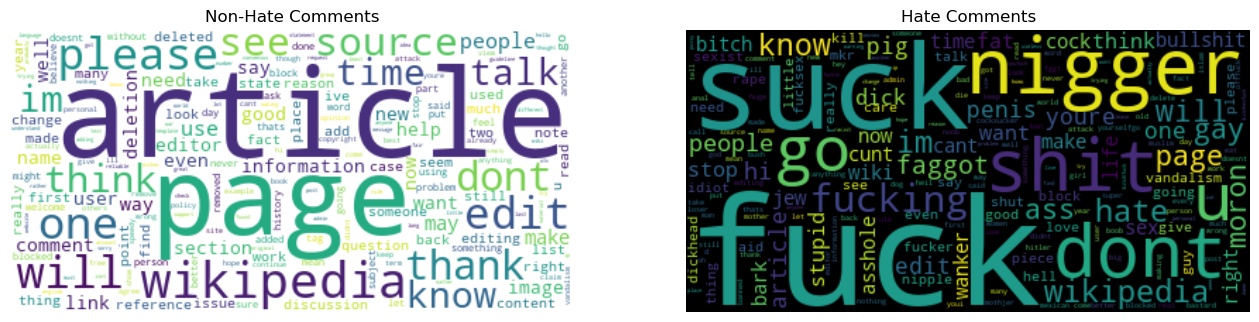

In [13]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['tweet'][train.label == 0])
text_neg = " ".join(train_clean['tweet'][train.label == 1])
# Generate word clouds for Non-Hate Comments and Hate Comments
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
# Display word cloud for Non-Hate Comments in the first subplot
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
# Display word cloud for Hate Comments in the second subplot
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

Visualizing Word Clouds for Non-Hate and Hate Comments
Here, We used word clouds to understand and visualise the textual content of dataset.
It helped us in identifying Common Themes by detecting the most frequent words in each category of comments.
Also this helped in Exploring Language Patterns thus gaining insights into the linguistic characteristics and sentiment of the comments in each category.Features derived from the most significant words in the word clouds can be used to build classification models that distinguish between non-hate and hate comments effectively.

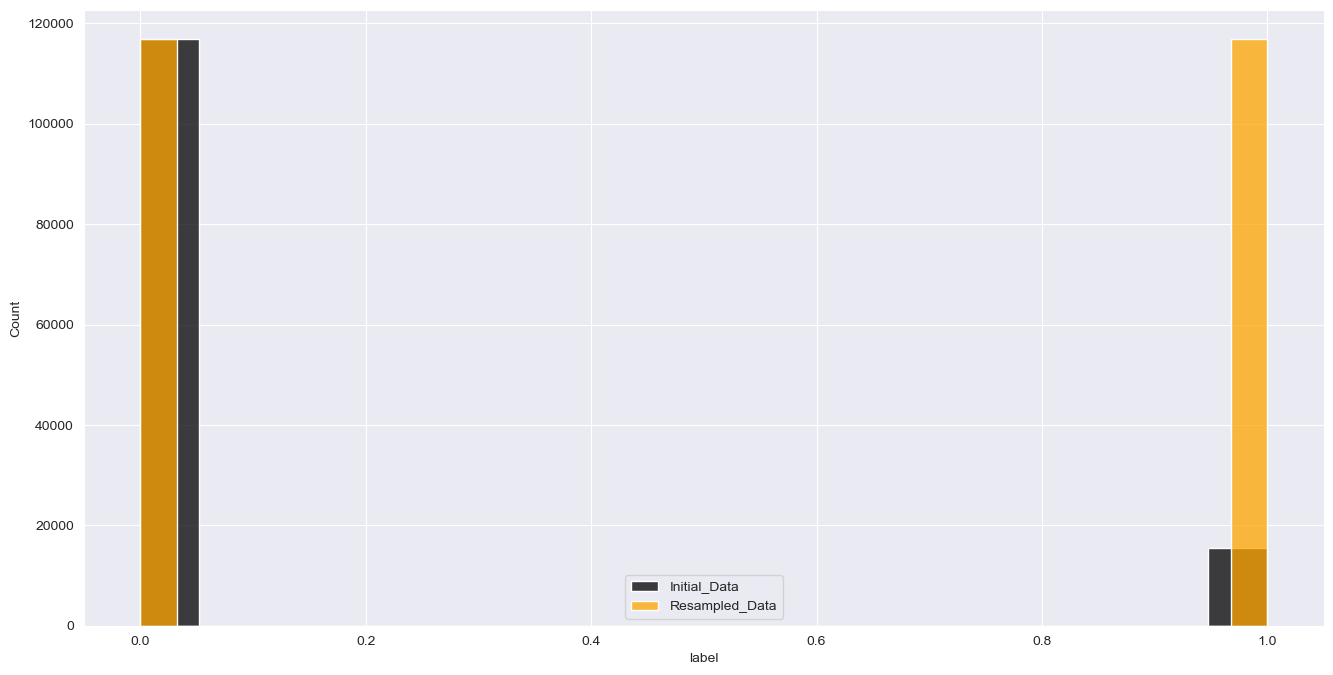

In [14]:
# Plot a histogram for the original training data
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

--------------After Upsampling the Minority Class---------------


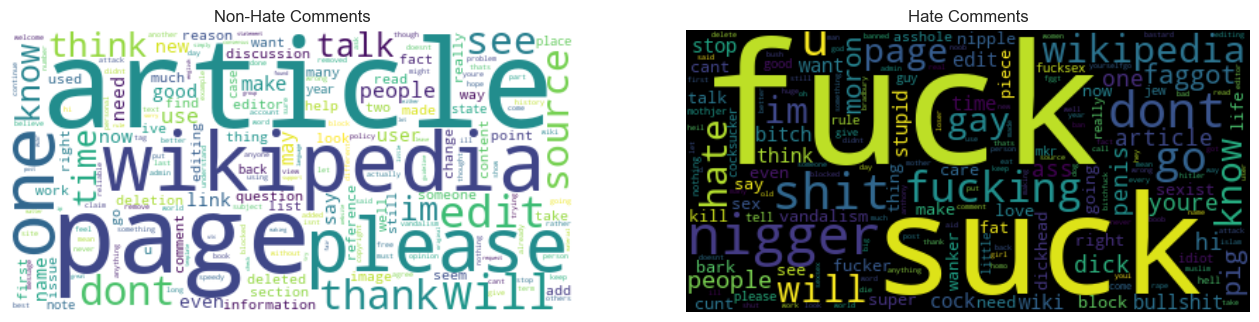

In [15]:
print('--------------After Upsampling the Minority Class---------------')

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_upsampled['tweet'][train.label == 0])
text_neg = " ".join(train_upsampled['tweet'][train.label == 1])
# Generate word clouds for Non-Hate Comments and Hate Comments
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
# Display word cloud for Non-Hate Comments in the first subplot
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
# Display word cloud for Hate Comments in the second subplot
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [18]:
new_transformed_dt = train_upsampled[['label', 'tweet']]
y = new_transformed_dt.iloc[:, :-1].values

In [19]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y = np.array(ct.fit_transform(y))
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [20]:
print(y.shape)

(233722, 2)


In [21]:
y_df = pd.DataFrame(y)
y_hate = np.array(y_df[0])
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [22]:
cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(train_upsampled['tweet']).toarray()
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
x.shape

(233722, 2000)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y_hate, test_size = 0.25, random_state = 1)

# testing various models

In [25]:
# Using Naive Bayes Classifier

classifier_np = GaussianNB()

# Start timer
start_time = time.time()

classifier_np.fit(x_train, y_train)

# End timer
end_time = time.time()

In [26]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Naive Bayes: {training_time:.6f} seconds")

Training time of Naive Bayes: 40.312376 seconds


In [27]:
# Using Decision Tree

classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

# Start timer
start_time = time.time()

classifier_dt.fit(x_train, y_train)

# End timer
end_time = time.time()

In [28]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Decision Tree: {training_time:.6f} seconds")

Training time of Decision Tree: 534.671721 seconds


In [29]:
# Using KNN

classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# Start timer
start_time = time.time()

classifier_knn.fit(x_train, y_train)

# End timer
end_time = time.time()

In [31]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of KNN: {training_time:.6f} seconds")

Training time of KNN: 0.036393 seconds


In [51]:
# Using Logistic Regression

classifier_lr = LogisticRegression(random_state = 0, max_iter = 500000)

# Start timer
start_time = time.time()

classifier_lr.fit(x_train, y_train)

# End timer
end_time = time.time()

In [52]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Logistic Regression: {training_time:.6f} seconds")

Training time of Logistic Regression: 229.500755 seconds


In [34]:
# Using Random Forest

classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

# Start timer
start_time = time.time()

classifier_rf.fit(x_train, y_train)

# End timer
end_time = time.time()

In [35]:
# Calculate training time
training_time = end_time - start_time

print(f"Training time of Random Forest: {training_time:.6f} seconds")

Training time of Random Forest: 104.276622 seconds


# confusion matrix

[[14826 14493]
 [  704 28408]]


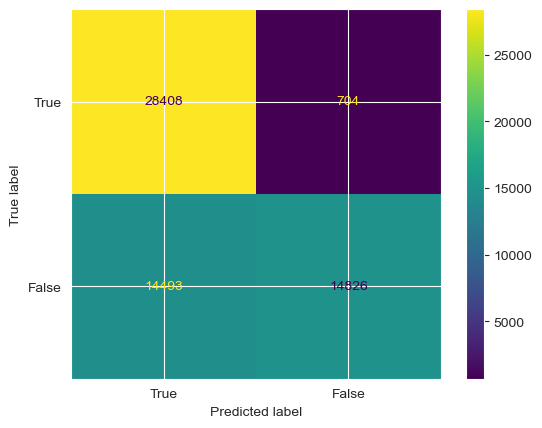

In [39]:
#Naive Bayes
y_pred_np = classifier_np.predict(x_test)
cm = confusion_matrix(y_test, y_pred_np)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_np, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [40]:
yhat_np = classifier_np.predict_proba(x_test)
print('y_hat_shape for Naive Bayes: ',yhat_np.shape)
yhat_np = yhat_np[:, 1]
fpr_np, tpr_np, _ = metrics.roc_curve(y_test, yhat_np)
auc_np = round(metrics.roc_auc_score(y_test, yhat_np), 4)

y_hat_shape for Naive Bayes:  (58431, 2)


[[29129   190]
 [ 2338 26774]]


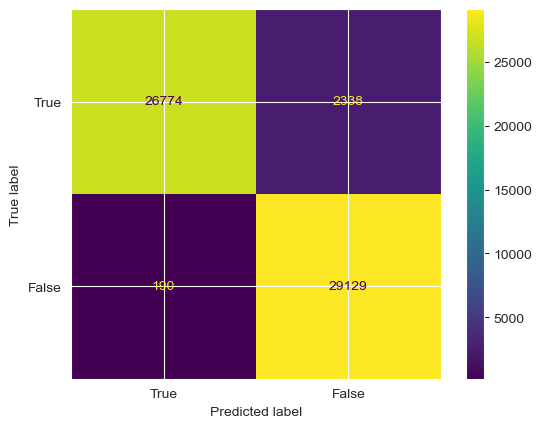

In [42]:
#Decision Tree
y_pred_dt = classifier_dt.predict(x_test)
cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_dt, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [43]:
yhat_dt = classifier_dt.predict_proba(x_test)
print('y_hat_shape for Decision Tree: ',yhat_dt.shape)
yhat_dt = yhat_dt[:, 1]
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test, yhat_dt)
auc_dt = round(metrics.roc_auc_score(y_test, yhat_dt), 4)

y_hat_shape for Decision Tree:  (58431, 2)


[[28515   804]
 [ 6596 22516]]


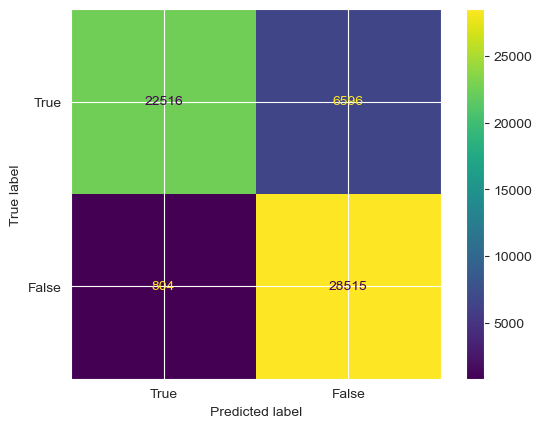

In [44]:
#KNN
y_pred_knn = classifier_knn.predict(x_test)
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_knn, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [45]:
yhat_knn = classifier_knn.predict_proba(x_test)
print('y_hat_shape for KNN: ',yhat_knn.shape)
yhat_knn = yhat_knn[:, 1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test, yhat_knn)
auc_knn = round(metrics.roc_auc_score(y_test, yhat_knn), 4)

y_hat_shape for KNN:  (58431, 2)


[[24846  4473]
 [ 2771 26341]]


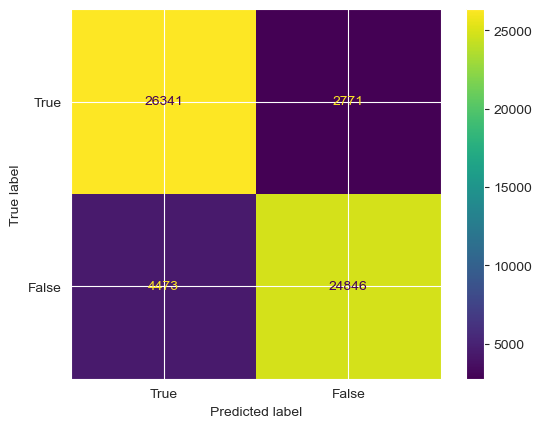

In [46]:
#Logistic Regression
y_pred_lr=classifier_lr.predict(x_test)
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_lr, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [47]:
yhat_lr = classifier_lr.predict_proba(x_test)
print('y_hat_shape for Logistic Regression: ',yhat_lr.shape)
yhat_lr = yhat_lr[:, 1]
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, yhat_lr)
auc_lr = round(metrics.roc_auc_score(y_test, yhat_lr), 4)

y_hat_shape for Logistic Regression:  (58431, 2)


[[29103   216]
 [ 1190 27922]]


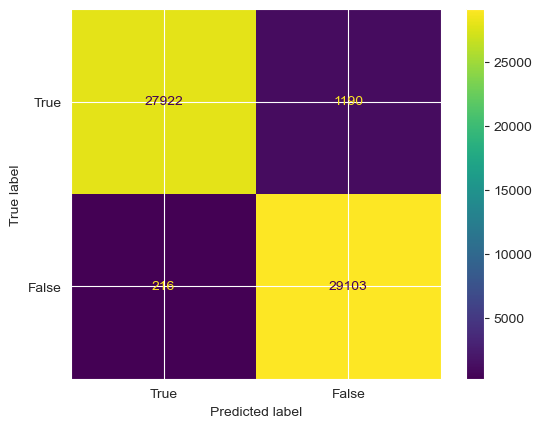

In [48]:
#Random Forest
y_pred_rf = classifier_rf.predict(x_test)
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_rf, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

In [49]:
yhat_rf = classifier_rf.predict_proba(x_test)
print('y_hat_shape for Random Forest: ',yhat_rf.shape)
yhat_rf = yhat_rf[:, 1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, yhat_rf)
auc_rf = round(metrics.roc_auc_score(y_test, yhat_rf), 4)

y_hat_shape for Random Forest:  (58431, 2)


In [50]:
rf_score = accuracy_score(y_test, y_pred_rf)
knn_score = accuracy_score(y_test, y_pred_knn)
#svm_score = accuracy_score(y_test, y_pred_svm)
lr_score = accuracy_score(y_test, y_pred_lr)
dt_score = accuracy_score(y_test, y_pred_dt)
np_score = accuracy_score(y_test, y_pred_np)

print ('--' * 20)
print('Random Forest Accuracy: ', str(rf_score))
print('F1 score: ', f1_score(y_test, y_pred_rf, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('K-Nearest Neighbors Accuracy: ', str(knn_score))
print('F1 score: ', f1_score(y_test, y_pred_knn, labels = [1,0]))
print ('--' * 20)
print ('')
'''print ('--' * 20)
print('Support Vector Machine Accuracy: ', str(svm_score))
print('F1 score: ', f1_score(y_test, y_pred_svm, labels = [1,0]))
print ('--' * 20)
print ('')'''
print ('--' * 20)
print('Logistic Regression Accuracy: ',str(lr_score))
print('F1 score: ', f1_score(y_test, y_pred_lr, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Naive Bayes Accuracy: ', str(np_score))
print('F1 score: ', f1_score(y_test, y_pred_np, labels = [1,0]))
print ('--' * 20)
print ('')

----------------------------------------
Random Forest Accuracy:  0.97593743047355
F1 score:  0.9754410480349346
----------------------------------------

----------------------------------------
K-Nearest Neighbors Accuracy:  0.8733548972292106
F1 score:  0.8588648153799208
----------------------------------------

----------------------------------------
Logistic Regression Accuracy:  0.8760247129092433
F1 score:  0.8791175783466274
----------------------------------------

----------------------------------------
Decision Tree Accuracy:  0.9567352946210059
F1 score:  0.9549183251301806
----------------------------------------

----------------------------------------
Naive Bayes Accuracy:  0.739915455836799
F1 score:  0.7889686584366712
----------------------------------------



In [2]:
#from sklearn.metrics import plot_precision_recall_curve

#plot_precision_recall_curve(classifier_np, x_test, y_test, ax = plt.gca(),name = "Naive Bayes")

#plot_precision_recall_curve(classifier_dt, x_test, y_test, ax = plt.gca(),name = "Decision Tree")

#plot_precision_recall_curve(classifier_knn, x_test, y_test, ax = plt.gca(),name = "K-Nearest Neighbors")

#plot_precision_recall_curve(classifier_lr, x_test, y_test, ax = plt.gca(),name = "Logistic Regression")

#plot_precision_recall_curve(classifier_rf, x_test, y_test, ax = plt.gca(),name = "Random Forest")

#plt.title('Precision-Recall curve')

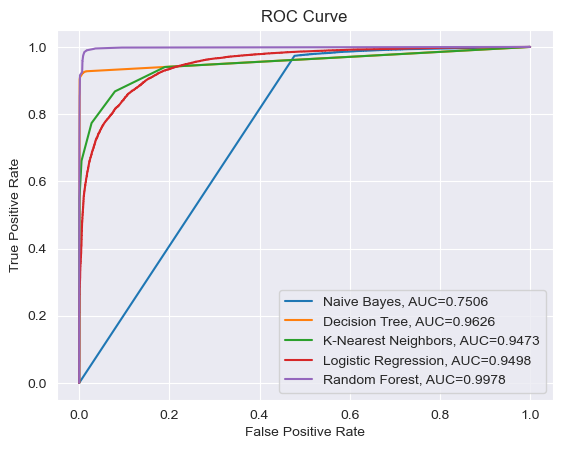

In [54]:
plt.plot(fpr_np,tpr_np,label="Naive Bayes, AUC="+str(auc_np))
plt.plot(fpr_dt,tpr_dt,label="Decision Tree, AUC="+str(auc_dt))
plt.plot(fpr_knn,tpr_knn,label="K-Nearest Neighbors, AUC="+str(auc_knn))
plt.plot(fpr_lr,tpr_lr,label="Logistic Regression, AUC="+str(auc_lr))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, AUC="+str(auc_rf))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')

#add legend
plt.legend()

In [30]:
# Splitting the data1 DataFrame into training and testing sets in 75:25
#train1, test1 = train_test_split(data1, test_size=0.25,random_state=10, shuffle=True)
#print("Training Set 1 :"% train1.columns, train1.shape)
#test1 = pd.read_csv('test_tweets_anuFYb8.csv')
#print("Test Set 1 :"% test1.columns, test1.shape)

#print('Train Set 1 -----')
#print(train1.isnull().sum())
#print('Test Set 1 -----')
#print(test1.isnull().sum())
#train1.head()